In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) #stardard deviation#* 0.2
#b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [10]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch contruction
    ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    #forward pass
    emb = C[Xb]  # (N, block_size, 2)
    embcat = emb.view(emb.shape[0], -1)  # (N, block_size*2)
    #linear layer
    hpreact = embcat @ W1 #+ b1
    #BatchNorm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch norm

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)  
     
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if  i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

#print(loss.item())
    #break



      0/ 200000: 3.3239


KeyboardInterrupt: 

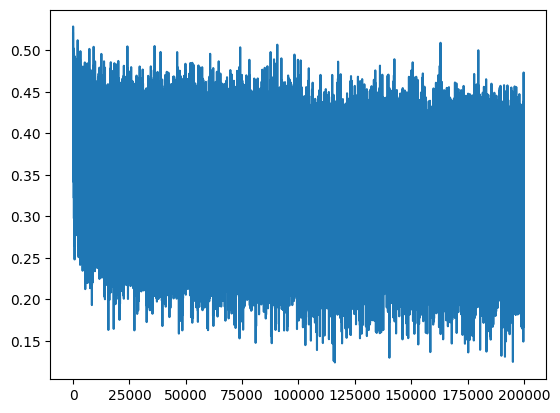

In [9]:
plt.plot(lossi)

In [ ]:
#calibrate the batch norm at the end of training

with torch.no_grad():
    emb = C[Xtr]  # (N, block_size, 2)
    embcat = emb.view(emb.shape[0], -1)  # (N, block_size*2)
    hpreact = embcat @ W1 
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]  # (N, block_size, 2)
    embcat = emb.view(emb.shape[0], -1)  # (N, block_size*2)
    hpreact = embcat @ W1 #+b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # batch norm
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # batch norm
    h = torch.tanh(hpreact)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

NameError: name 'torch' is not defined

In [8]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):

    out = []
    context = [0] * block_size #itialize with start token
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, 2)
        h = torch.tanh(emb.view(1,-1) @ W1)
        logits = h @ W2 + b2  # (1,27)
        probs = F.softmax(logits, dim=1)  # (1,27)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))



NameError: name 'C' is not defined

In [54]:
#Deeper network time

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running "momentum average")
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calc forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=False)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):

    #minibatch contruction
    ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    #forward pass
    emb = C[Xb]  # (N, block_size, 2)
    x = emb.view(emb.shape[0], -1)  # (N, block_size*2)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  
     
    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if  i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad.std())/ p.data.std()).log10().item() for p in parameters])

#print(loss.item())
    if i >= 1000:
        break



      0/ 200000: 3.2868


layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.65, saturated: 2.81%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.44%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.13%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 2.09%


Text(0.5, 1.0, 'Activation distributions per layer')

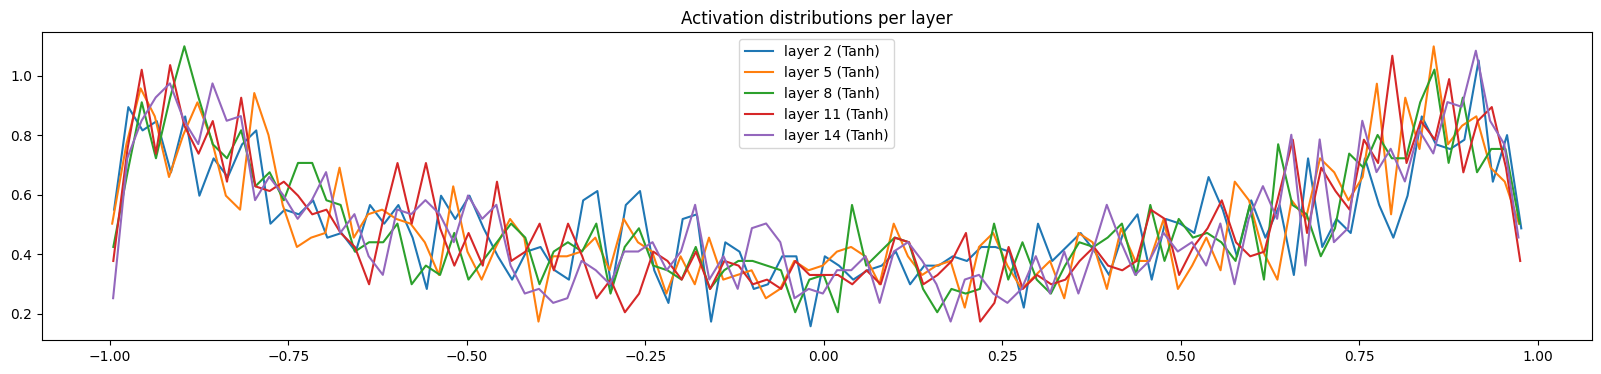

In [56]:
#visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), ( (t.abs()>0.97).float().mean().item()*100 ) ))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title("Activation distributions per layer")

layer 2 (      Tanh): mean -0.000000, std 3.644342e-03
layer 5 (      Tanh): mean -0.000000, std 3.246818e-03
layer 8 (      Tanh): mean -0.000000, std 2.962462e-03
layer 11 (      Tanh): mean -0.000000, std 2.736549e-03
layer 14 (      Tanh): mean -0.000000, std 2.577498e-03


Text(0.5, 1.0, 'gradient distributions per layer')

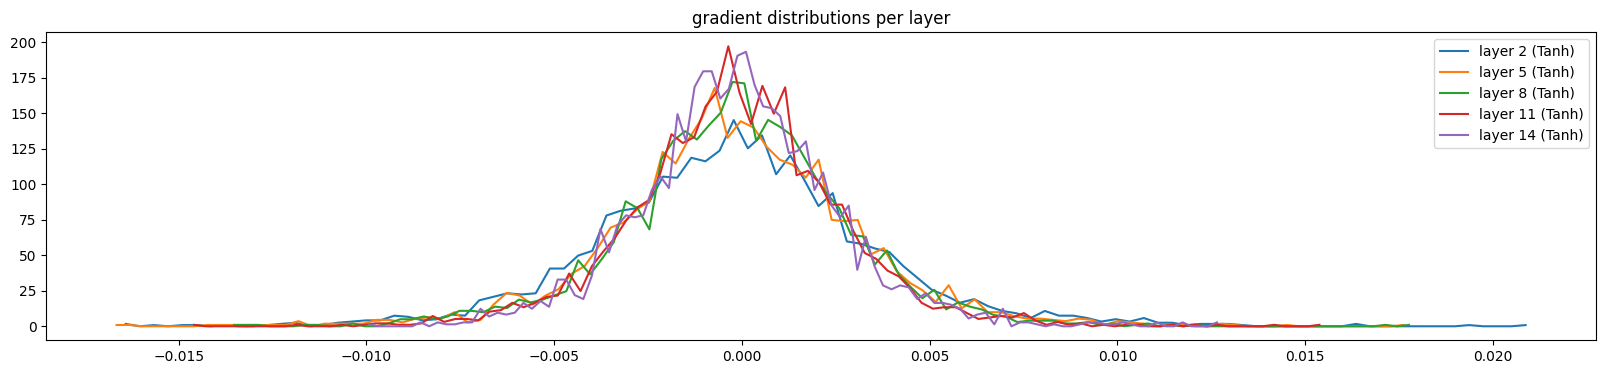

In [57]:
#visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title("gradient distributions per layer")

weight   (27, 10) | mean +0.000000 | std 1.007701e-02 | grad:data ratio 1.006667e-02
weight  (30, 100) | mean +0.000082 | std 8.225078e-03 | grad:data ratio 2.631421e-02
weight (100, 100) | mean +0.000024 | std 7.317645e-03 | grad:data ratio 4.376286e-02
weight (100, 100) | mean -0.000019 | std 6.695946e-03 | grad:data ratio 3.969676e-02
weight (100, 100) | mean -0.000016 | std 5.858741e-03 | grad:data ratio 3.490114e-02
weight (100, 100) | mean +0.000054 | std 5.468969e-03 | grad:data ratio 3.257319e-02
weight  (100, 27) | mean -0.000148 | std 1.053031e-02 | grad:data ratio 6.317417e-02


Text(0.5, 1.0, 'weights gradient distributions')

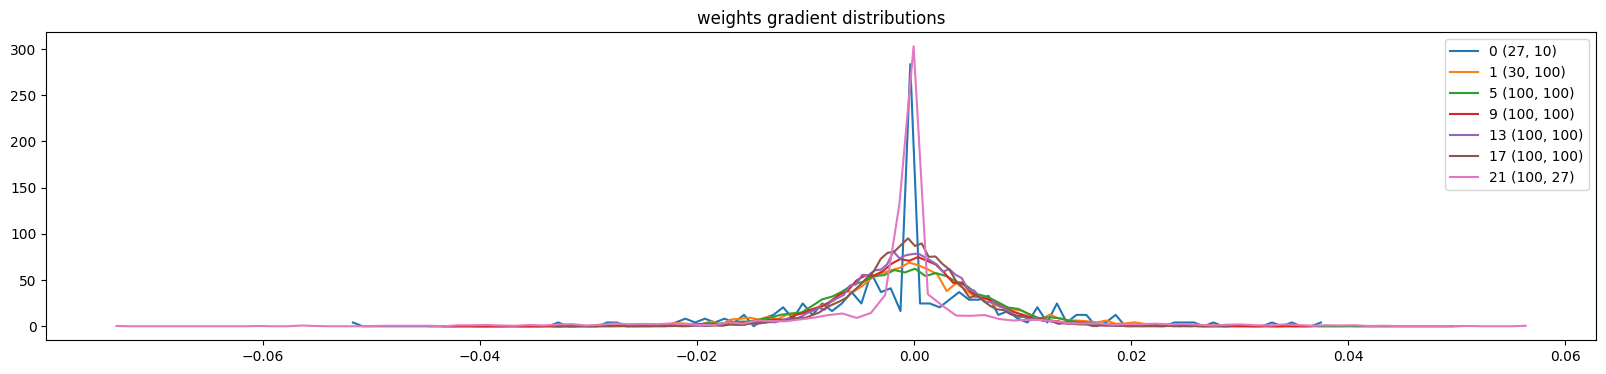

In [58]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
        t = p.grad
        if p.ndim == 2:
            print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), (t.std()/p.std())))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title("weights gradient distributions")

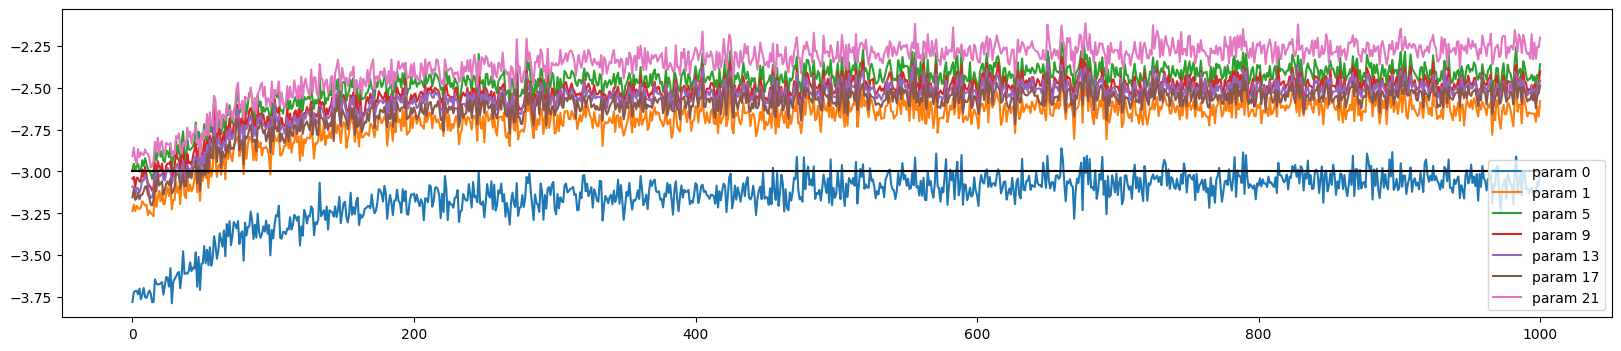

In [59]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)] , [-3, -3], 'k')
plt.legend(legends)